# Time Series Anomaly Detection - Part 1 

## Introduction

Based on this walkthrough: http://amid.fish/anomaly-detection-with-k-means-clustering


For this tutorial, I used an EKG timeseries from here: http://ecg.mit.edu/time-series/

In [104]:
from __future__ import print_function
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import numpy as np
import learn_utils
import ekg_data

In [105]:
ekg_filename = 'physio.dat'
ekg_data = ekg_data.read_ekg_data(ekg_filename)
print(ekg_data.shape)

(3182000,)


The simplest way to detect an anomaly is if a value passes a given threshold.  But what happens if the waveform shape/structure prevents this? Here, we try to learn the shape of a normal waveform. 

This tutorial does anomaly detection on a waveform using KMeans Clustering. 

**Overview of kmeans algorithm**
1. K initial means are chosen in the data 
2. Go through every observation and assign it to the nearest mean 
3. Calculate the centroid of each of the K clusters 
4. Repeat over and over until "convergence" 

**Applying KMeans to a waveform timeseries:** 

KMeans requires a bunch of observations that live in n-dimensional space. We can split the waveform timeseries into segments that form the basis of observations. But the "Features" themselves -- the things we will cluster -- will actually be waveform segments that we represent as points in hyperdimensional space. 





## Training 

1. split the waveform into `n` segments 
2. form a space in `n` dimensions. Each waveform segments is one point 
3. Use k-means to find the centroids of each k cluster 

The result of this will be clusters containing "classifiable groups" of "normal waveforms." 


In [106]:
print("ekg_data[0]:\t", ekg_data[0])
print("ekg_data[1]:\t", ekg_data[1])
print("ekg_data.min:\t", ekg_data.min())
print("ekg_data.max:\t", ekg_data.max())

ekg_data[0]:	 -4.0
ekg_data[1]:	 -4.0
ekg_data.min:	 -572.0
ekg_data.max:	 580.0


In [111]:
ekg_data = ekg_data[0:8192]

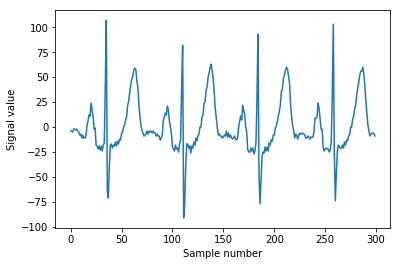

In [112]:
%matplotlib inline

n_samples_to_plot = 300
plt.plot(ekg_data[0:n_samples_to_plot])
plt.xlabel("Sample number")
plt.ylabel("Signal value")
plt.show()

The first step is "windowing." I'm going to slide along the timeseries two signals at a time, in order to capture the transition segments between signals. 

In [113]:
segment_len = 32
slide_len = 2

segments = []
for start_pos in range(0, len(ekg_data), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original ekg_data
    segment = np.copy(ekg_data[start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

Produced 4081 waveform segments


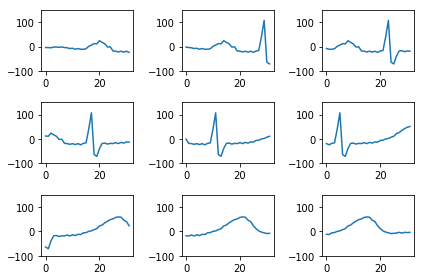

In [114]:
learn_utils.plot_waves(segments, step=3)

We ideally want all our segments to be zero-valued (waveform starts and ends at zero), so we apply a window function (multiply each segment by the first half of a sine wave)

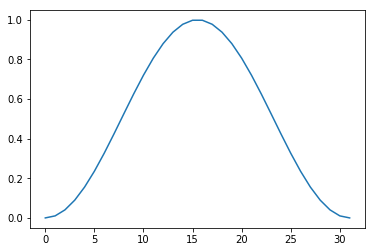

In [115]:
window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
plt.plot(window)
plt.show()

In [116]:
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)

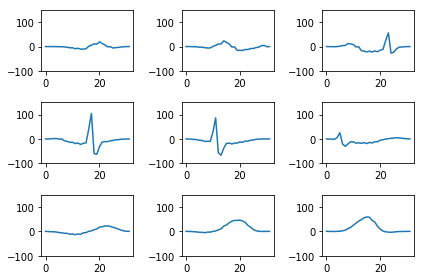

In [118]:
# zero value windowed segments 
learn_utils.plot_waves(windowed_segments, step=3)


### Clustering 

We're going to run Kmeans with 150 clusters, meaning we're compiling a library of 150 "normal-ish" waveform types.



In [119]:
clusterer = KMeans(n_clusters=150)
clusterer.fit(windowed_segments)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=150, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

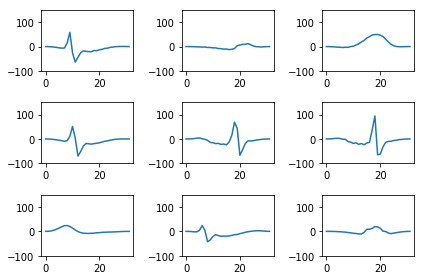

In [122]:
# output the centroids, or our learned "normal" waveform shapes 
learn_utils.plot_waves(clusterer.cluster_centers_, step=15)


## Testing 

We'll now use the learned waveform clusters to:

1. Try to reconstruct the original waveform 
2. Detect anomalies within this original waveform 

For the reconstruction step, we again split the original waveform into overlapping segments. 

In [123]:
slide_len = segment_len/2
test_segments = learn_utils.sliding_chunker(
    ekg_data,
    window_len=segment_len,
    slide_len=slide_len
)

Then we find the cluster centroid that best matches the segment. 

Example:

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


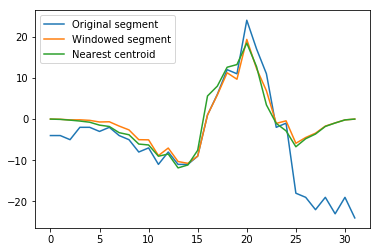

In [131]:
centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[0])
windowed_segment = segment * window
# use scikit learn's KMeans.predict function
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict
nearest_centroid_idx = clusterer.predict(windowed_segment)[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])
plt.figure()
plt.plot(segment, label="Original segment")
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.legend()
plt.show()

Do this for all the segments: 

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

Maximum reconstruction error was 13.8
98th percentile of reconstruction error was 6.1


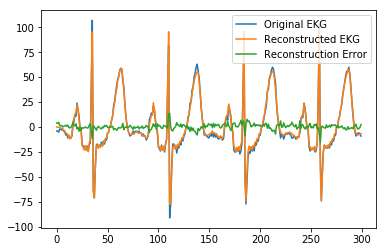

In [136]:

reconstruction = np.zeros(len(ekg_data))
slide_len = segment_len/2

for segment_n, segment in enumerate(test_segments):
    segment = np.copy(segment)
    segment *= window
    nearest_centroid_idx = clusterer.predict(segment)[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    pos = segment_n * slide_len
    reconstruction[pos:pos+segment_len] += nearest_centroid

n_plot_samples = 300

error = reconstruction[0:n_plot_samples] - ekg_data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(ekg_data[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

## Anomaly Detection

Manually inject a zero-valued anomaly into the original waveform:

In [137]:
ekg_data_anomalous = np.copy(ekg_data)
ekg_data_anomalous[210:215] = 0

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

Maximum reconstruction error was 55.6
98th percentile of reconstruction error was 13.4


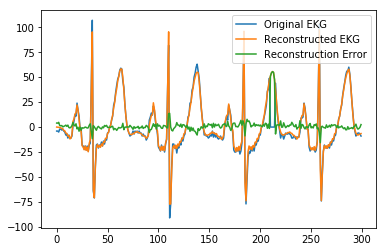

In [138]:
recontruction = \
    learn_utils.reconstruct(ekg_data_anomalous, window, clusterer)
    
error = reconstruction[0:n_plot_samples] - ekg_data_anomalous[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(ekg_data_anomalous[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

Sure enough, at the sample #200 mark, you see a high (55%) reconstruction error. The tutorial suggests using a simple threshold detector to report high reconstruction errors, and thus report potential anomalies. 